<a href="https://colab.research.google.com/github/sunmyeonglee/2025-1-NLP/blob/main/1_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec Implementation from Scratch

This notebook demonstrates how to implement the Word2Vec algorithm from scratch using PyTorch. We'll use the first Harry Potter book as our corpus to train word embeddings.


## 1. Setting Up the Environment

First, we need to import the necessary libraries:
- `torch` and `torch.nn` for tensor operations and neural network functionality
- `string` for string manipulations (removing punctuation)


In [1]:
import torch
import torch.nn as nn
import string


## 2. Getting the Text Data

We'll download the first Harry Potter book to use as our corpus.

In [2]:
!wget "https://raw.githubusercontent.com/amephraim/nlp/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%201%20-%20Sorcerer's%20Stone.txt"


--2025-03-27 04:26:29--  https://raw.githubusercontent.com/amephraim/nlp/master/texts/J.%20K.%20Rowling%20-%20Harry%20Potter%201%20-%20Sorcerer's%20Stone.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 439742 (429K) [text/plain]
Saving to: ‘J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt’

J. K. Rowling - Har 100%[===================>] 429.44K  --.-KB/s    in 0.06s   

2025-03-27 04:26:29 (6.60 MB/s) - ‘J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt’ saved [439742/439742]



## 3. Text Preprocessing

Before we can use the text data, we need to preprocess it:
- Remove punctuation
- Convert text to lowercase
- Split text into tokens (words)

This function will help us clean and tokenize the text.

In [3]:
def remove_punctuation(x):
  return x.translate(''.maketrans('', '', string.punctuation))

def make_tokenized_corpus(corpus):
  out= [ [y.lower() for y in remove_punctuation(sentence).split(' ') if y] for sentence in corpus]
  return [x for x in out if x!=[]]


## 4. Loading and Formatting the Text

Now we'll load the text file, replace some special characters, and split the text into sentences.


In [4]:
with open("J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt", 'r') as f:
  strings = f.readlines()
list_of_sentences = "".join(strings).replace('\n', ' ').replace('Mr.', 'mr').replace('Mrs.', 'mrs').split('. ')

Let's tokenize the text using our preprocessing function `make_tokenized_corpus`:

In [5]:
# Corpus is a list of list of strings (words)

for sentence in list_of_sentences[:10]:
  print(sentence)

Harry Potter and the Sorcerer's Stone   CHAPTER ONE  THE BOY WHO LIVED  mr and mrs Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much
They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense
 mr Dursley was the director of a firm called Grunnings, which made drills
He was a big, beefy man with hardly any neck, although he did have a very large mustache
mrs Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors
The Dursleys had a small son called Dudley and in their opinion there was no finer boy anywhere
 The Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it
They didn't think they could bear it if anyone found out about the Potters
mrs Potter was

In [6]:
corpus = make_tokenized_corpus(list_of_sentences)

type(corpus), type(corpus[0]), type(corpus[0][0])

(list, list, str)

## 5. Creating Context Word Pairs

A key concept in Word2Vec is learning from context. We need to create pairs of words that appear near each other in the text. We'll use a sliding window approach to create these pairs.

For example, with the window size of 2, for the word "to" in the sentence "they were the last people youd expect to be involved...", we would create pairs with:
- ("to", "expect")
- ("to", "be")
- ("to", "involved")
- ("to", "in")

These pairs will be our training data.

In [7]:
from tqdm import tqdm

sample_sentence = ['they', 'were', 'the', 'last', 'people', 'youd', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because', 'they', 'just', 'didnt', 'hold', 'with', 'such', 'nonsense']

word_pairs = []
window_size = 2

for sample_sentence in tqdm(corpus):
  for cur_idx, center_word in enumerate(sample_sentence):
    window_begin = max(cur_idx - window_size, 0)
    window_end = min(cur_idx + window_size + 1, len(sample_sentence))
    # for context_word in sample_sentence[window_begin:window_end]:
    #   # if center_word == context_word: continue
    #   word_pairs.append( (center_word, context_word))
    for j in range(window_begin, window_end):
      if cur_idx == j: continue
      word_pairs.append( (center_word, sample_sentence[j]))

print(f"\nLength of word_pairs is {len(word_pairs)}")
print(f"First 5 example of word_pairs is {word_pairs[:5]}")

100%|██████████| 4682/4682 [00:00<00:00, 8800.65it/s]


Length of word_pairs is 282372
First 5 example of word_pairs is [('harry', 'potter'), ('harry', 'and'), ('potter', 'harry'), ('potter', 'and'), ('potter', 'the')]


## 6. Building the Vocabulary

To work with word vectors, we need to create a vocabulary that maps each unique word to an index. We'll also filter out rare words that appear less than a certain number of times in the corpus.

### 6.1 Collecting All Words

First, let's collect all words in our corpus:


In [8]:
# we have to make vocabulary
sentence = corpus[0]
entire_words = []

for sentence in corpus:
  for word in sentence:
    entire_words.append(word)

len(entire_words)

77597


### 6.2 Finding Unique Words

Now, let's find the unique words in our corpus:

In [9]:
# we have to get the "unique" item among total words

vocab_set = set(entire_words)
len(vocab_set)

unique_words = list(vocab_set)
len(unique_words)

6038

### 6.3 Converting to a List and Sorting

We'll convert the set of unique words to a sorted list:

In [10]:
# vocab_set[0] # set is not subscriptable because it has no order

unique_words = sorted(list(unique_words))
unique_words[0]

'\the'

### 6.4 Filtering by Frequency

Now, let's filter out rare words that occur less than a specified number of times:
- We can use the `Counter` class from the `collections` module to count the frequency of each word in the corpus.
- Caution on `alist.sort()` will return `None`.

In [11]:
# how can we filter the vocab by its frequency?
filtered_vocab = None
# you can use word counter as dictionary
# In python dictionary, dict.keys() gives keys, and dict.values() give values,
# dict.items() give (key, value)

from collections import Counter
word_counter = Counter(entire_words)
word_counter.most_common(10)
word_counter['harry']

threshold = 5
filtered_vocab = []
for key, value in word_counter.items():
  if value > threshold:
    filtered_vocab.append(key)

filtered_vocab.sort()
filtered_vocab[:10]

['a',
 'able',
 'abou',
 'about',
 'above',
 'across',
 'added',
 'afford',
 'afraid',
 'after']

## 7. Filtering Word Pairs

Now that we have our filtered vocabulary, we need to filter our word pairs to only include words that are in our vocabulary:

In [12]:
# Filter the word_pairs using the vocab
# word_pairs, filtered_vocab
# word_pairs is a list of [word_a, word_b]

filtered_word_pairs = []
vocab_set = set(filtered_vocab)

for pair in tqdm(word_pairs):
  a, b = pair
  if a in filtered_vocab and b in filtered_vocab:
    filtered_word_pairs.append(pair)

100%|██████████| 282372/282372 [00:14<00:00, 19541.60it/s]


In [13]:
# implement same algorithm with list comprehension

filtered_word_pairs = [pair for pair in word_pairs if pair[0] in vocab_set and pair[1] in vocab_set]

In [14]:
len(filtered_word_pairs), len(word_pairs)

(226846, 282372)

## 8. Converting Words to Indices

For efficiency, we'll convert our words to indices according to their position in our vocabulary:

In [15]:
# convert word into index of vocab
# filtered_vocab.index('happily')
filtered_vocab.index('harry')

527

This is inefficient because `list.index()` has to scan the list every time. Let's use a dictionary for faster lookups:

In [16]:
# we can make it faster
# use dictionary to find the index of string
word2idx = dict()
for idx, word in enumerate(filtered_vocab):
  word2idx[word] = idx

word2idx['harry']

527

Now, let's convert our word pairs to index pairs more efficiently:

In [17]:
index_pairs = [(word2idx[pair[0]], word2idx[pair[1]]) for pair in filtered_word_pairs]
index_pairs[0]

(527, 953)

In [18]:
# Why we don't need idx2tok?

filtered_vocab[527]

'harry'

## 9. Creating Initial Word Vectors

Now we'll create random vectors for each word in our vocabulary. These vectors will be adjusted during training:
- We can use `torch.randn` to create random vectors that follow normal distribution.

In [19]:
# we have to make random vectors for each word in the vocab
# we also have to decide the dimension of the vector

dim = 100
vocab_size = len(filtered_vocab)

word_vectors = torch.randn(vocab_size, dim) / dim ** 0.5
word_vectors

tensor([[-0.0039, -0.0132,  0.0306,  ..., -0.2251, -0.0883, -0.0780],
        [ 0.0087, -0.0513,  0.1240,  ...,  0.0181,  0.1080, -0.0013],
        [ 0.0428, -0.0833, -0.0558,  ...,  0.0198,  0.1067,  0.0584],
        ...,
        [-0.0225, -0.0932,  0.0323,  ..., -0.1122, -0.0098,  0.0578],
        [-0.1467, -0.2946, -0.0369,  ..., -0.1944,  0.0291,  0.0371],
        [ 0.1634, -0.0023, -0.0396,  ..., -0.0037,  0.0359,  0.0007]])

In [20]:
# what is the vector for harry?
word_vectors[word2idx['harry']]

tensor([ 0.0347,  0.0097, -0.1745, -0.1108,  0.0955, -0.0299, -0.1880, -0.0730,
         0.0063,  0.0325,  0.1199, -0.0225, -0.0570,  0.0811, -0.1121, -0.0258,
        -0.0211, -0.0510, -0.1001, -0.0829, -0.1335, -0.1573,  0.0228,  0.3139,
         0.1000, -0.0136,  0.0557, -0.0939,  0.0649,  0.0431, -0.1296,  0.0283,
        -0.0605,  0.1312,  0.1316,  0.1278, -0.1840,  0.0721, -0.2079,  0.1430,
         0.0493, -0.0241, -0.0351, -0.0729,  0.0218,  0.0673, -0.1201,  0.0345,
        -0.0379, -0.0365, -0.0627, -0.1535,  0.0080,  0.0159, -0.0142, -0.0642,
        -0.0637,  0.1281, -0.0136, -0.1404,  0.2779,  0.1085, -0.1176, -0.0518,
        -0.0418,  0.0391, -0.0661, -0.1507, -0.0971, -0.1463,  0.1127,  0.0988,
         0.0957,  0.0760,  0.1998, -0.0615,  0.0342, -0.0384,  0.0005,  0.0451,
         0.0550, -0.1598, -0.0536,  0.0600, -0.0609, -0.1395, -0.1332,  0.0577,
        -0.0660,  0.0337, -0.1576,  0.0438,  0.0638, -0.0353,  0.0062, -0.0049,
         0.0555,  0.0160,  0.0824, -0.05

## 10. Understanding Word Relationships with Dot Products

The core of Word2Vec is using dot products to measure relationships between words. Let's explore this concept:

In [21]:
torch.set_printoptions(sci_mode=False) # Do this to avoid scientific notation

## Dot Product
- Assume we have two vectors $a$ and $b$.
  - $a = [a_1, a_2, a_3, a_4, ..., a_n]$
  - $b = [b_1, b_2, b_3, b_4, ..., b_n]$
- $a \cdot b$ = $\sum _{i=1}^n a_ib_i$  = $a_1b_1 + a_2b_2 + a_3b_3 + a_4b_4 + ... + a_nb_n$

Let's calculate the dot product between "harry" and "potter":


In [22]:
# calculate P(potter|harry)
harry = word_vectors[word2idx['harry']]
potter = word_vectors[word2idx['potter']]
dot_product_value_between_potter_harry = sum(harry * potter)
dot_product_value_between_potter_harry

tensor(-0.0057)

In [23]:
# we can get the dot product value for every other words in the vocab
# to get  P(word | harry)
word_dot_dict = {}
for word in filtered_vocab:
  w_idx = word2idx[word]
  w_vector = word_vectors[w_idx]
  word_dot_dict[word] = sum(harry * w_vector)
word_dot_dict

{'a': tensor(-0.0915),
 'able': tensor(-0.0140),
 'abou': tensor(0.0766),
 'about': tensor(0.1487),
 'above': tensor(0.2486),
 'across': tensor(0.0983),
 'added': tensor(0.1583),
 'afford': tensor(-0.0539),
 'afraid': tensor(0.0185),
 'after': tensor(0.0300),
 'afternoon': tensor(0.0717),
 'again': tensor(-0.1002),
 'against': tensor(0.1221),
 'ages': tensor(0.0078),
 'ago': tensor(-0.0893),
 'agreed': tensor(-0.0126),
 'ah': tensor(0.1042),
 'ahead': tensor(-0.0998),
 'air': tensor(0.0521),
 'albus': tensor(0.0516),
 'alive': tensor(0.0129),
 'all': tensor(0.0975),
 'alley': tensor(-0.0053),
 'allowed': tensor(0.1409),
 'almost': tensor(0.1099),
 'alone': tensor(0.0488),
 'along': tensor(0.0290),
 'already': tensor(-0.0485),
 'also': tensor(0.0115),
 'although': tensor(-0.0530),
 'always': tensor(0.1434),
 'am': tensor(-0.0566),
 'an': tensor(0.0788),
 'and': tensor(0.1218),
 'angrily': tensor(0.0627),
 'angry': tensor(0.0898),
 'another': tensor(0.0418),
 'answer': tensor(0.0737),
 '

Now, let's convert these dot products to probabilities using the softmax function:
- We have to convert our prediction into probability distribution to get P(word|harry) so that sum of [P(a|harry), ..., P(potter|harry), ... P(ron|harry), ... ] = 1
- current dot product value is any real number, sometimes called as logit
  - logit from logistic regression. Some values that are not yet converted to 0-1 or value before sigmoid function
  - every probability should be in range (0, 1) (greater than 0, smaller than 1)
  - this can be handled by taking exponential of dot product values, divided by total sum
  - This function is called **Softmax**

- Why we use exponential?
  - Because we want to make every probability in positive range while preserving the order


In [24]:
from math import exp
word_exp_dict = {}
for word, dot_value in word_dot_dict.items():
  exp_value = torch.exp(dot_value)
  word_exp_dict[word] = exp_value

sum_exp = sum([value for value in word_exp_dict.values()])
word_prob_dict = {}
for word, exp_value in word_exp_dict.items():
  word_prob_dict[word] = exp_value / sum_exp

word_prob_dict

{'a': tensor(0.0006),
 'able': tensor(0.0007),
 'abou': tensor(0.0007),
 'about': tensor(0.0008),
 'above': tensor(0.0008),
 'across': tensor(0.0007),
 'added': tensor(0.0008),
 'afford': tensor(0.0006),
 'afraid': tensor(0.0007),
 'after': tensor(0.0007),
 'afternoon': tensor(0.0007),
 'again': tensor(0.0006),
 'against': tensor(0.0007),
 'ages': tensor(0.0007),
 'ago': tensor(0.0006),
 'agreed': tensor(0.0007),
 'ah': tensor(0.0007),
 'ahead': tensor(0.0006),
 'air': tensor(0.0007),
 'albus': tensor(0.0007),
 'alive': tensor(0.0007),
 'all': tensor(0.0007),
 'alley': tensor(0.0007),
 'allowed': tensor(0.0008),
 'almost': tensor(0.0007),
 'alone': tensor(0.0007),
 'along': tensor(0.0007),
 'already': tensor(0.0006),
 'also': tensor(0.0007),
 'although': tensor(0.0006),
 'always': tensor(0.0008),
 'am': tensor(0.0006),
 'an': tensor(0.0007),
 'and': tensor(0.0007),
 'angrily': tensor(0.0007),
 'angry': tensor(0.0007),
 'another': tensor(0.0007),
 'answer': tensor(0.0007),
 'any': tenso

In [25]:
# Get P(potter|harry)
word_prob_dict['harry']

tensor(0.0018)

## 13. Efficient Matrix Operations
![img](https://mkang32.github.io/images/python/khan_academy_matrix_product.png)

Instead of calculating dot products one by one, we can use matrix multiplication for efficiency:


In [26]:
harry, potter
center_word_mat = torch.stack([harry, potter])
center_word_mat.shape

torch.Size([2, 100])

In [27]:
# get dot product result for every word in the vocabulary
harry.shape
# first, make vector_of_harry into matrix format
harry_mat = harry.unsqueeze(0)
word_vectors.shape
# do matrix multiplication
dot_by_mat = torch.mm(center_word_mat, word_vectors.T)
dot_by_mat = dot_by_mat.T
dot_by_mat.shape

torch.Size([1506, 2])

Let's verify that our matrix multiplication gives the same result as individual dot products:

In [28]:
dot_by_mat[word2idx['potter']], word_dot_dict['potter']

(tensor([-0.0057,  0.9501]), tensor(-0.0057))

Now let's implement the complete softmax calculation using matrix operations:


In [29]:
# convert dot product result into exponential
mat_exp = torch.exp(dot_by_mat)
mat_exp.shape

torch.Size([1506, 2])

In [30]:
# get the sum of exponential
sum(mat_exp)
sum_of_mat_exp = torch.sum(mat_exp, dim=1, keepdim=True)
sum_of_mat_exp

tensor([[1.8485],
        [1.9712],
        [2.1687],
        ...,
        [1.9100],
        [1.8822],
        [1.9644]])

In [31]:
# divide exponential value with sum
prob = mat_exp / sum(mat_exp)
prob.sum(dim=0)

tensor([1.0000, 1.0000])

## 14. Creating a Probability Function

Let's create a function to calculate probabilities efficiently:

In [32]:
def get_probs(query_vectors, entire_vectors):
  dot_by_mat = torch.mm(query_vectors, entire_vectors.T)
  dot_by_mat = dot_by_mat.T
  mat_exp = torch.exp(dot_by_mat)
  sum_of_mat_exp = torch.sum(mat_exp, dim=0)
  prob = mat_exp / sum_of_mat_exp
  return prob

get_probs(center_word_mat, word_vectors)

tensor([[0.0006, 0.0006],
        [0.0007, 0.0007],
        [0.0007, 0.0007],
        ...,
        [0.0006, 0.0006],
        [0.0006, 0.0007],
        [0.0007, 0.0006]])

## 15. Preparing for Training

Before training our Word2Vec model, we need to split our dataset into training and testing sets:

In [33]:
# Now we can train the word2vec
import random,

# Let's think about training pairs
index_pairs # this is our dataset. It's list of list of two integer
print(len(index_pairs))
# two integer means a pair of neighboring words

# Training set and Test set
# To validate that our model can solve 'unseen' problems
# So we have to split the dataset before training.

# To randomly split the dataset, we will first shuffle the dataset

random.shuffle(index_pairs) # this will shuffle the list items

226846


In [34]:
train_set = index_pairs[:200000]
test_set = index_pairs[200000:]

In [35]:
len(train_set), len(test_set)

(200000, 26846)

## 16. Training the Word2Vec Model

Now we'll train our Word2Vec model using batched gradient descent:

In [41]:
# making batch from train_set
# Batch is a set of training samples, that are calculated together
# And also we update the model after one single batch

word_vectors.requires_grad = True
batch = train_set[:20]
batch
center_words = [x[0] for x in batch]
context_words = [x[1] for x in batch]

center_words_vectors = word_vectors[center_words]
prob = get_probs(center_words_vectors, word_vectors)
prob.shape

torch.Size([1506, 20])

In [48]:
learning_rate = 0.01

def update_word_vectors(center_words, context_words, word_vectors, learning_rate=0.01, return_loss_only=False) :
  center_words_vectors = word_vectors[center_words]
  prob=get_probs(center_words_vectors,entire_vectors=word_vectors)
  # print(context_words)
  # idx=0
  # for idx in range(len(context_words)):
  #   prob_of_correct_context_word_for_given_idx = prob[context_words[idx],idx]
  #   #print(prob_of_correct_context_word_for_given_idx)
  prob_of_correct_context_word = prob[context_words, torch.arange(len(context_words))]
  negative_log_likelihood = -torch.log(prob_of_correct_context_word)
  loss=negative_log_likelihood.mean()
  # backprop the loss
  loss.backward()
  # word_vectors.grad
  if not return_loss_only:
    word_vectors.data = word_vectors.data - word_vectors.grad * learning_rate
    word_vectors.grad = None
    word_vectors.data.grad = None
  return loss.item()

0.28415900468826294

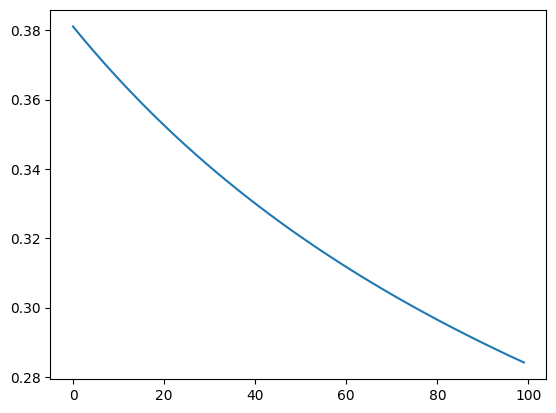

In [43]:
import matplotlib.pyplot as plt

loss_record=[]
for i in range(100):

  loss = update_word_vectors(center_words,context_words,word_vectors, learning_rate=0.1)
  loss_record.append(loss)
plt.plot(loss_record)
loss

In [96]:
from tqdm.auto import tqdm

# batch = train_set[:20]
# batch
# center_words = [x[0] for x in batch]
# context_words = [x[1] for x in batch]
batch_size=100
batch_start_idx = 0
batch_end_idx=batch_start_idx+batch_size

loss_record = []
test_loss_record = []
n_epoch = 10

for epoch in tqdm(range(n_epoch)):
  for batch_start_idx in range(0, len(train_set), batch_size):
    batch=train_set[batch_start_idx:batch_start_idx+batch_size]
    center_words = [x[0] for x in batch]
    context_words = [x[1] for x in batch]
    loss = update_word_vectors(center_words,context_words,word_vectors, learning_rate=0.1)
    loss_record.append(loss)
  center_words = [x[0] for x in test_set]
  context_words = [x[1] for x in test_set]
  test_loss = update_word_vectors(center_words,context_words,word_vectors, learning_rate=0.1,return_loss_only=True)
  test_loss_record.append(test_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

In [97]:
def validate(model, test_set):
    loss = update_word_vectors(center_words,context_words,word_vectors, learning_rate=0.1, return_loss_only=True)
    loss_record.append(loss)


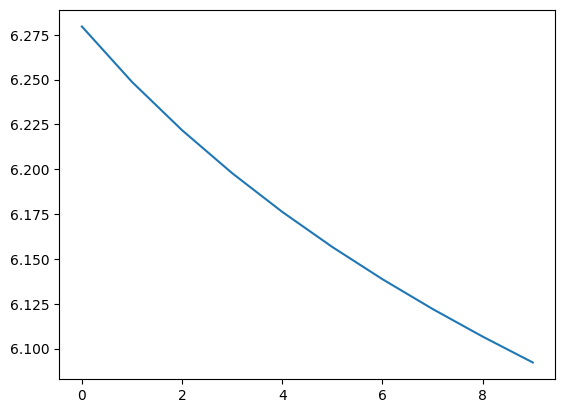

In [98]:
plt.plot(test_loss_record)

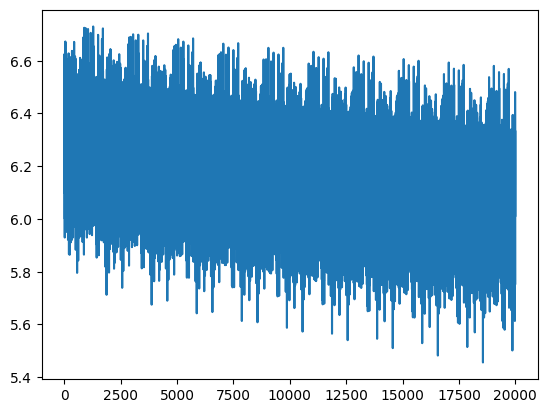

In [99]:
plt.plot(loss_record)

## 17. Evaluating the Training

Let's visualize the training loss to see if our model is learning:

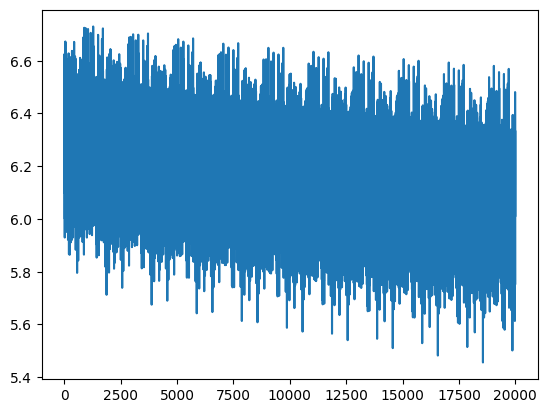

In [100]:
import matplotlib.pyplot as plt
plt.plot(loss_record)

## 18. Testing the Model

Now we'll test our model on the test set:

In [101]:
harry_vector = word_vectors[word2idx['ron']]
prob = get_probs(harry_vector.unsqueeze(dim=0), word_vectors)
idx = prob.argsort(dim=0)[-10:].squeeze()
for i in idx:
  print(filtered_vocab[i], prob[i])
# prob.argmax()
# unique_words[527]

the tensor([0.0114], grad_fn=<SelectBackward0>)
to tensor([0.0122], grad_fn=<SelectBackward0>)
at tensor([0.0134], grad_fn=<SelectBackward0>)
hagrid tensor([0.0159], grad_fn=<SelectBackward0>)
he tensor([0.0160], grad_fn=<SelectBackward0>)
hermione tensor([0.0272], grad_fn=<SelectBackward0>)
and tensor([0.0311], grad_fn=<SelectBackward0>)
harry tensor([0.0430], grad_fn=<SelectBackward0>)
ron tensor([0.0517], grad_fn=<SelectBackward0>)
said tensor([0.0525], grad_fn=<SelectBackward0>)


In [102]:
harry = word_vectors[word2idx['harry']]
ron = word_vectors[word2idx['ron']]
boat = word_vectors[word2idx['boat']]

dot_product = sum(harry * ron)
cosine_similarity = dot_product / (harry**2).sum().sqrt() / (ron**2).sum().sqrt()
cosine_similarity

tensor(0.9169, grad_fn=<DivBackward0>)

In [103]:
dot_product_mat = (harry*word_vectors).sum(dim=1)
# dot_product_mat.shape
cosine_similarity = dot_product_mat/(harry**2).sum().sqrt() / (word_vectors**2).sum(dim=1).sqrt()
# cosine_similarity[word2idx['ron']]
similar_words = cosine_similarity.argsort(descending=True)
for i in similar_words[:10]:
  print(filtered_vocab[i])

harry
ron
said
he
and
but
hagrid
asked
it
that


## 19. Exploring Learned Word Relationships

Let's explore what our model has learned by finding the words most closely related to "harry":

In [ ]:
# P(potter|harry)?
